In [1]:
#데이터 구성: Series, DataFrame
import pandas as pd

#행렬 연산
import numpy as np

#통계분석 패키지
import scipy.stats
from scipy import stats

#datetime
import datetime


#데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
#데이터 시각화: 추세, 산점도 행렬
import seaborn as sns

# grhpviz
from sklearn.tree import export_graphviz
import graphviz


#데이터 분할
from sklearn.model_selection import train_test_split

# 로지스틱 회귀
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score

# 의사결정나무
from sklearn.tree import DecisionTreeClassifier

# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

# 그레디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier

# 모델 성능 평가
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

#선형회귀모형
from sklearn.linear_model import LinearRegression

#변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

#Scale 변환:평균, 표준편차 기준
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

#평가함수
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#jupyter notebook 사용시 그래프 자동 출력 옵션
%matplotlib inline
matplotlib.rc('font', family='AppleGothic')
plt.rc('font',  family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

In [2]:
df = pd.read_csv('wo_thin.csv', engine='python', encoding='cp949')

# 원래 데이터의 연체/연체X 비율
과거(2020년 전) 씬파일러 제외 1849명 중, 2020년 이후 연체인 사람 312명

In [3]:
ratio = (df['is_overdue'].count()-df['is_overdue'].sum())/df['is_overdue'].sum()
print('Class imbalance ratio = {}: 1'.format(ratio.round(1)))

Class imbalance ratio = 4.9: 1


In [4]:
print(df['is_overdue'].count())
print(df['is_overdue'].sum())

1849
312.0


In [5]:
y = df[['is_overdue']]

# X = df.drop(['is_overdue', 'credit_class', 'score_risk', 'age', 'income_home_grp', 'income_ind_grp', 'expenditure_grp', 'income_person', 'chaju_id', 'job', 'house_type'], axis=1)
X = df[['gender', 'agegroup', 'dwell_type', 'child_cd', 'flag_priv_biz_cd', 'card_count', 'loan_dur', 'loan_count', 'over_dur', 'over_count']]

dwell_mapping = {'자가': '자가', '전세': '전세', '월세': '월세', '영구임대': '월세', '사택/기타': '월세'}
X['dwell_type'] = X['dwell_type'].map(dwell_mapping)

# X[['sum_loan_at_time', 'loan_amt', 'over_amt', 'sum_cashservice_3y', 'sum_cardloan_3y', 'sum_creditcard_over']] = np.log10(X[['sum_loan_at_time', 'loan_amt', 'over_amt', 'sum_cashservice_3y', 'sum_cardloan_3y', 'sum_creditcard_over']]+1)

X = pd.get_dummies(X, drop_first=True)

<ipython-input-5-35d7d39a5b98>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dwell_type'] = X['dwell_type'].map(dwell_mapping)


In [6]:
y.value_counts()

is_overdue
0.0           1537
1.0            312
dtype: int64

# Resampling
y=1인 데이터의 개수를 y=0인 데이터 개수(1537)로 증가시키키 (1.0, 312)=>(1.0, 1537)

In [7]:
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

"""
class 비율이 1000:100인 경우=>100인 class를 1000으로 늘려준다.
majority class had 1,000 examples and the minority class had 100, 
this strategy would oversampling the minority class so that it has 1,000 examples.

"""
oversample = RandomOverSampler(sampling_strategy='minority')#sampling_strategy=1)#sampling_strategy='minority')

# fit_resample에 넣는 X,y type은 numpy.ndarray여야 한다.
X_over, y_over = oversample.fit_resample(X.to_numpy(), y.to_numpy())
print('y after resampling', sorted(Counter(y_over).items()))
print('y_over: oversampling 완료한 y의 총 개수 1537*2 = ', len(y_over))
print(len(X_over))
# under = RandomUnderSampler(sampling_strategy=555/1537)
# X_over, y_over = under.fit_resample(X_over, y_over)
# print('y after resampling', sorted(Counter(y_over).items()))

y after resampling [(0.0, 1537), (1.0, 1537)]
y_over: oversampling 완료한 y의 총 개수 1537*2 =  3074
3074


In [40]:
# resampling된 train, test 데이터
train_x_resampled, dummy, train_y_resampled, dummy = train_test_split(X_over, y_over, test_size=0.35, stratify=y_over, random_state=0)
print(len(train_y_resampled))

1998


In [41]:
dummy, test_x_select, train_y, test_y_select = train_test_split(X, y, test_size=0.3, stratify=y,random_state=0)

In [11]:
a = pd.DataFrame(train_y_resampled)
a.value_counts()

1.0    999
0.0    999
dtype: int64

In [12]:
print('train_y_resampled')
print(a[a==0].count()/a[a==1].count())

train_y_resampled
0    1.0
dtype: float64


In [46]:
a = pd.DataFrame(test_y_select)
a.value_counts()

is_overdue
0.0           461
1.0            94
dtype: int64

In [47]:
print('test_y_select')
print(a[a==0].count()/a[a==1].count())

test_y_select
is_overdue    4.904255
dtype: float64


# 모델 입성 전 train, test set 정의

In [54]:
# print(len(train_y_resampled))

# train_y_select, dummy = train_test_split(train_y_resampled, test_size=0.3, stratify=train_y_resampled, random_state=0)
# print(len(train_y_select))

# dummy, train_y_select = train_test_split(train_y_resampled, test_size=len(train_y_test)/len(train_y_resampled), stratify=train_y_resampled,random_state=0)
# print(len(train_y_select))

# train_x_select, dummy = train_test_split(train_x_resampled, test_size=0.3, stratify=train_x_resampled, random_state=0)
# print(len(train_x_select))

1998
1398


In [46]:
# len(train_y_select)

1398

In [50]:
# len(train_x)

1998

In [57]:
# a = pd.DataFrame(train_y_select)
# a = pd.DataFrame(train_y_resampled)
# a.value_counts()

1.0    999
0.0    999
dtype: int64

In [58]:
# print('train_y_select')
# print(a[a==0].count()/a[a==1].count())

train_y_select
0    1.0
dtype: float64


In [68]:
train_x = train_x_resampled
train_y = train_y_resampled
test_x = test_x_select
test_y = test_y_select
print('train_x',train_x.shape)
print('train_y',train_y.shape)
print('test_x',test_x.shape)
print('test_y',test_y.shape)

# train_y 최종
## 연체X : 연체 = 1 : 1 (oversampled)

In [61]:
a = pd.DataFrame(train_y)
a.value_counts()

1.0    999
0.0    999
dtype: int64

In [62]:
print('train_y 최종의 연체X/연체 비율')
print(a[a==0].count()/a[a==1].count())

train_y 최종의 연체X/연체 비율
0    1.0
dtype: float64


# test_y 최종
## 연체X : 연체 = 4.9 : 1 (원래 데이터 비율)

In [63]:
a = pd.DataFrame(test_y)
a.value_counts()

is_overdue
0.0           461
1.0            94
dtype: int64

In [64]:
print('test_y 최종의 연체X/연체 비율')
print(a[a==0].count()/a[a==1].count())

test_y 최종의 연체X/연체 비율
is_overdue    4.904255
dtype: float64


# RandomForest

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
random_forest_model1 = RandomForestClassifier(n_estimators = 20, # 20번 추정
                                             max_depth = 5, # 트리 최대 깊이 5
                                             random_state = 42) # 시드값 고정
rf_final = random_forest_model1.fit(train_x, train_y) # 학습 진행
print("Accuracy: %.2f" % (accuracy_score(test_y, rf_final.predict(test_x)) * 100), "%") # 정확도 % 계산

Accuracy: 92.97 %


In [71]:
y_pred=rf_final.predict(test_x)
print("Accuracy on trainig set: {}".format(rf_final.score(train_x,train_y)))
print("Accuracy on test set: {}".format(rf_final.score(test_x,test_y)))

print("Confusion matrix: \n{}".format(confusion_matrix(test_y,y_pred)))

print(classification_report(test_y,y_pred,digits=3))

Accuracy on trainig set: 0.9164164164164165
Accuracy on test set: 0.9297297297297298
Confusion matrix: 
[[440  21]
 [ 18  76]]
              precision    recall  f1-score   support

         0.0      0.961     0.954     0.958       461
         1.0      0.784     0.809     0.796        94

    accuracy                          0.930       555
   macro avg      0.872     0.881     0.877       555
weighted avg      0.931     0.930     0.930       555



In [72]:
df_importance = pd.DataFrame()
feature_name = X.columns
df_importance['Feature'] = feature_name
df_importance['Importance'] = rf_final.feature_importances_
df_importance.sort_values('Importance', ascending=True, inplace=True)
df_importance.round(3)


,Feature,Importance
10,agegroup_70대,0.001
7,agegroup_40대,0.001
11,agegroup_80대이상,0.001
8,agegroup_50대,0.001
6,agegroup_30대,0.002
13,dwell_type_전세,0.002
12,dwell_type_자가,0.002
5,gender_여성,0.004
9,agegroup_60대,0.004
15,flag_priv_biz_cd_Y,0.005


Text(0, 0.5, '변수')

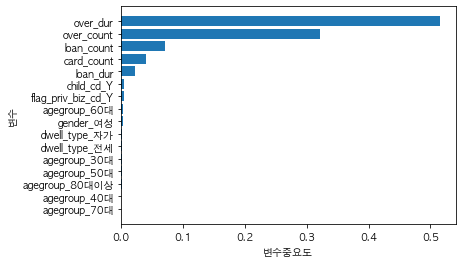

In [73]:
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수중요도')
plt.ylabel('변수')